Trying to replicate results from https://www.researchgate.net/profile/Salma-Alhagry/publication/320802497_Emotion_Recognition_based_on_EEG_using_LSTM_Recurrent_Neural_Network/links/5b39ff5a0f7e9b0df5e4cf26/Emotion-Recognition-based-on-EEG-using-LSTM-Recurrent-Neural-Network.pdf



In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io
import scipy.signal
from einops import reduce, rearrange
import numpy as np

In [2]:
# Constants used to define data paths
ROOT_DIR = './'
RAW_DIR = 'data/matlabPREPROCESSED'
PROCESSED_DIR = 'data/graphProcessedData'

In [3]:
raw_file_names = os.listdir(RAW_DIR)
raw_file_names.sort()
all_subjects = [scipy.io.loadmat(f'{RAW_DIR}/{name}') for name in raw_file_names]

In [4]:
all_data = [subject['data'] for subject in all_subjects]
all_labels = [subject['labels'] for subject in all_subjects]
labels = np.stack(all_labels)
data = np.stack(all_data)

In [5]:
data = data[:,:,:32,:]

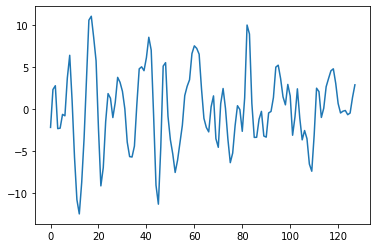

In [6]:
import matplotlib.pyplot as plt
plt.plot(data[0,0,2,:128].T)
plt.show()

In [7]:
data.shape

(32, 40, 32, 8064)

In [8]:
all_labels = rearrange(labels,'s v c -> (s v) c')
all_data = rearrange(data,'s v c (d a) -> (s v) d (c a)', a=672)

In [9]:
data.shape, all_data.shape, labels.shape, all_labels.shape

((32, 40, 32, 8064), (1280, 12, 21504), (32, 40, 4), (1280, 4))

In [10]:
train_test_split = 0.75
target = 0 # valence
split_idx = int(all_labels.shape[0]*train_test_split)

In [11]:
all_data = torch.FloatTensor(all_data)
train_x, train_y = all_data[:split_idx], torch.FloatTensor(all_labels[:split_idx,target])
test_x, test_y = all_data[split_idx:], torch.FloatTensor(all_labels[split_idx:,target])
train_y = (train_y > 5).float()
test_y = (test_y > 5).float()

In [12]:
val_train_split = 0.9
split_idx = int(train_y.shape[0]*val_train_split)
val_x, val_y = train_x[split_idx:], train_y[split_idx:]
train_x, train_y = train_x[:split_idx], train_y[:split_idx]

In [13]:
train_x.shape, val_x.shape, test_x.shape, train_y.shape

(torch.Size([864, 12, 21504]),
 torch.Size([96, 12, 21504]),
 torch.Size([320, 12, 21504]),
 torch.Size([864]))

In [14]:
train_data = [(x,y) for x,y in zip(train_x,train_y)]
val_data = [(x,y) for x,y in zip(val_x,val_y)]
test_data = [(x,y) for x,y in zip(test_x,test_y)]

In [38]:
BS = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BS)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BS)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [36]:
class Model(torch.nn.Module):
    def __init__(self, in_channels,hidden_channels):
        super(Model, self).__init__()
        self.lstm1 = nn.LSTM(21504, 64, 1, batch_first=True).to(device)
        self.lstm2 = nn.LSTM(64, 32, 1, batch_first=True).to(device)
        self.lin = nn.Linear(32,1).to(device)
#         self.lstms = nn.ModuleList([nn.LSTM(in_channels, hidden_channels, 4, dropout=0.05, batch_first=True).to(device) for i in range(32)])
#         self.lin1 = nn.Linear(hidden_channels*32,hidden_channels).to(device)
#         self.lin2 = nn.Linear(hidden_channels,1).to(device)
        
    def forward(self, x):
        
#         print(x.shape)
        x, (h,c) = self.lstm1(x)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        o, (h,c) = self.lstm2(x)
        x = h.squeeze()
        x = x.sigmoid()
        x = self.lin(x)
        x = x.sigmoid()
        
        return x.view(-1)


In [40]:
model = Model(all_data.shape[-1],hidden_channels=8)     
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Model parameter count: {pytorch_total_params}')

# optimizer = torch.optim.Adadelta(model.parameters(), lr=.1, rho=0.9, eps=1e-06, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(),lr=1e-1, weight_decay=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=.05, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)

criterion = nn.BCELoss()

model = model.to(device)

def train():
    model.train()
    losses = []
    right = 0
    tot = 0
    for x,y in train_loader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        right += torch.eq(out > 0.5, y > 0.5).sum().item()
        tot += y.shape[0]
    return np.array(losses).mean(), right/tot

def test(loader,verbose=False):
    model.eval()
    losses = []
    right = 0
    tot = 0
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        if verbose:
            print(out,y)
        right += torch.eq(out > 0.5, y > 0.5).sum().item()
        tot += y.shape[0]
        loss = criterion(out,y)
        losses.append(loss.item())
    return np.array(losses).mean(), right/tot

best_val_loss = np.inf
esp = 0
MAX_ESP = 50
for epoch in range(1, 1000):
    train_loss, train_acc = train()
    val_loss, val_acc = test(val_loader)
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        esp = 0
    else:
        esp += 1
        if esp >= MAX_ESP:
            break
#     if epoch%5 == 0:
    print(f'Epoch {epoch} ;t loss: {train_loss:.5f} ;t acc: {train_acc:.2f} ;v loss: {val_loss:.5f} ;v acc: {val_acc:.2f}')

print('Finished training')

Model parameter count: 5534497
Epoch 1 ;t loss: 0.69014 ;t acc: 0.54 ;v loss: 0.70300 ;v acc: 0.48
Epoch 2 ;t loss: 0.68708 ;t acc: 0.54 ;v loss: 0.70567 ;v acc: 0.48
Epoch 3 ;t loss: 0.67354 ;t acc: 0.60 ;v loss: 0.72648 ;v acc: 0.48
Epoch 4 ;t loss: 0.65135 ;t acc: 0.64 ;v loss: 0.71568 ;v acc: 0.44
Epoch 5 ;t loss: 0.61942 ;t acc: 0.69 ;v loss: 0.73366 ;v acc: 0.46
Epoch 6 ;t loss: 0.58531 ;t acc: 0.73 ;v loss: 0.72487 ;v acc: 0.45
Epoch 7 ;t loss: 0.53711 ;t acc: 0.77 ;v loss: 0.80629 ;v acc: 0.41
Epoch 8 ;t loss: 0.50723 ;t acc: 0.79 ;v loss: 0.82771 ;v acc: 0.48
Epoch 9 ;t loss: 0.46144 ;t acc: 0.81 ;v loss: 0.86351 ;v acc: 0.52
Epoch 10 ;t loss: 0.42937 ;t acc: 0.82 ;v loss: 0.82733 ;v acc: 0.53
Epoch 11 ;t loss: 0.40623 ;t acc: 0.84 ;v loss: 0.83546 ;v acc: 0.53
Epoch 12 ;t loss: 0.37563 ;t acc: 0.85 ;v loss: 0.81054 ;v acc: 0.55
Epoch 13 ;t loss: 0.35975 ;t acc: 0.86 ;v loss: 0.92203 ;v acc: 0.45
Epoch 14 ;t loss: 0.31995 ;t acc: 0.88 ;v loss: 0.91536 ;v acc: 0.48
Epoch 15 ;t 

In [41]:
loss, acc = test(test_loader)
print(f'Test loss: {loss} ; Test acc: {acc}')

# TODO: esp, kfold val , scheduler(?)

Test loss: 1.6037564620142803 ; Test acc: 0.53125
